# Comparison between TMJets and GLGM06

In [28]:
using ReachabilityAnalysis, Plots, SparseArrays

## TMJets

In [4]:
@taylorize function platoon_connected!(du, u, p, t)
    
    uin = u[11] # input -9 .. 1

    du[1] = u[2]
    du[2] = -u[3] + uin
    du[3] = 1.6050 * u[1] + 4.8680*u[2] -3.5754*u[3] -0.8198*u[4]+ 0.4270*u[5] -0.0450*u[6] -0.1942*u[7]+  0.3626*u[8] -0.0946*u[9]
    du[4] = u[5]
    du[5] = u[3] - u[6]
    du[6] = 0.8718*u[1]+ 3.8140*u[2] -0.0754*u[3]+  1.1936*u[4]+ 3.6258*u[5] -3.2396*u[6] -0.5950*u[7] + 0.1294*u[8] -0.0796*u[9]
    du[7] = u[8]
    du[8] = u[6] - u[9]
    du[9] = 0.7132*u[1]+ 3.5730*u[2] -0.0964*u[3]+  0.8472*u[4]+ 3.2568*u[5] -0.0876*u[6]+  1.2726*u[7]+  3.0720*u[8] -3.1356*u[9]
    du[10] = one(u[10]) # time
    du[11] = zero(u[11]) # input
end

In [78]:
U0 = Hyperrectangle(low=vcat(zeros(10), -9.0), high=vcat(zeros(10), 1.0))
U = HalfSpace(vcat(zeros(9), [1.0], 0.0), 5.0) # t <= 5.0

prob = @ivp(u' = platoon_connected!(u), dim=11, u(0) ∈ U0, u ∈ U)
@time sol = solve(prob, T=20.0, alg=TMJets(abs_tol=1e-13));

  2.026355 seconds (11.20 M allocations: 1.603 GiB, 33.72% gc time)


In [79]:
solz = overapproximate(sol, Zonotope)

minx1 = -ρ(sparsevec([1], [-1.0], 11), solz)

-19.048689733538804

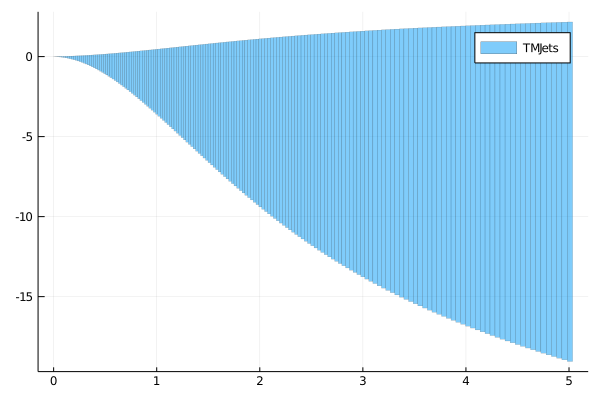

In [80]:
plot(solz, vars=(0, 1), lab="TMJets", lw=0.2)

## GLGM06

In [30]:
using ModelingToolkit

In [39]:
const var = @variables x[1:9] t

function platoon_connected()
    n = 9 + 1 # 9 space variables + time

    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, -0.8198, 0.4270, -0.0450, -0.1942,  0.3626, -0.0946, 0.]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0.8718, 3.8140, -0.0754,  1.1936, 3.6258, -3.2396, -0.5950,  0.1294, -0.0796, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    invariant = HalfSpace(t <= 5.0, var)

    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]

    return @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

platoon_connected (generic function with 1 method)

In [83]:
prob = @ivp(platoon_connected(), x(0) ∈ Singleton(zeros(10)))

InitialValueProblem{ConstrainedAffineControlContinuousSystem{Float64,Array{Float64,2},SparseMatrixCSC{Float64,Int64},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},Singleton{Float64,Array{Float64,1}}}(ConstrainedAffineControlContinuousSystem{Float64,Array{Float64,2},SparseMatrixCSC{Float64,Int64},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}([0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.7132 3.573 … -3.1356 0.0; 0.0 0.0 … 0.0 0.0], 
  [2, 1]  =  1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 5.0), Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-4.0], [5.0])), Singleton{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [86]:
@time sol = solve(prob, T=20.0, alg=GLGM06(δ=0.01, max_order=10));

  0.017111 seconds (24.56 k allocations: 24.109 MiB)


In [87]:
minx1 = -ρ(sparsevec([1], [-1.0], 10), sol)

-19.240448475456624

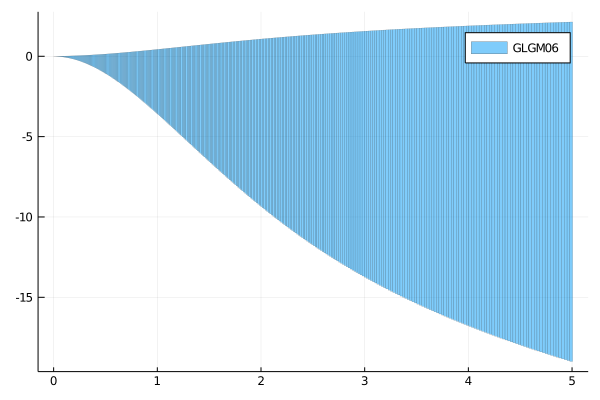

In [77]:
plot(solz, vars=(0, 1), lab="GLGM06", lw=0.2)